In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mice_dfi import plots

## Load data

In [2]:
df_validation = pd.read_csv('./generated/validation_data.csv')
df_validation_control = df_validation[df_validation.label.isin(['MA0071_F', 'MA0072_M',  'MA0071_M'])].copy()

## Fit data and plot

In [3]:
fileformat = 'svg'
os.makedirs('./figs',exist_ok=True)  # saving pngs
os.makedirs('./source',exist_ok=True)  # saving source data
bbox_inches = None # None  or 'tight'
production = True
plots.set_style(production=production)
cm = 1/2.54  # centimeters in inches
dpi=300
if production:
    fig_size = 8.8 * cm
    fontsize = 7
    scale=0.5
else:
    fig_size = 18. * cm
    fontsize = 16
    scale= 1

### Figure 5a

0 outliers remvoed in MA0071_F
0 outliers remvoed in MA0071_M
1 outliers remvoed in MA0072_M
1 outliers removed, 282 animals included


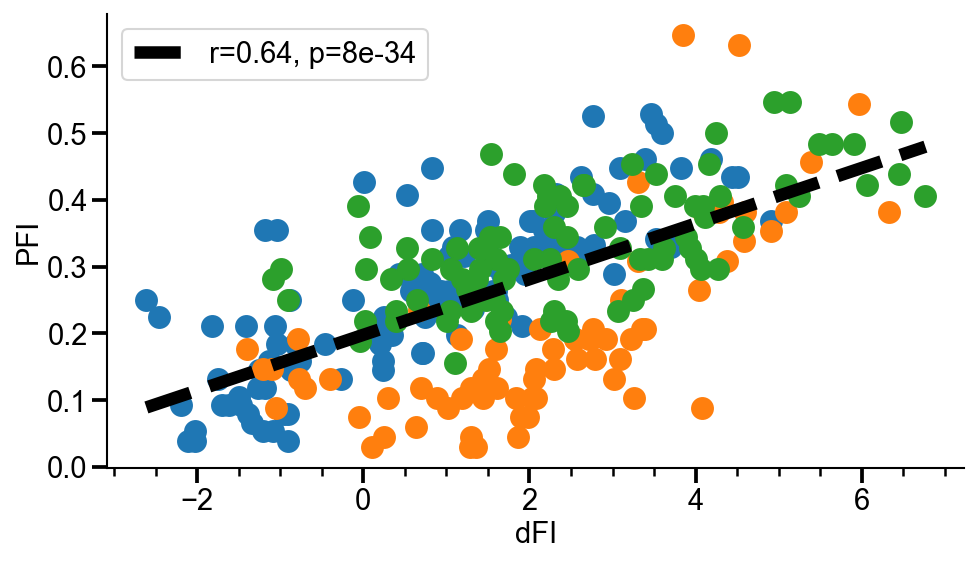

In [4]:
figsize=(fig_size, fig_size * 0.6)
figname = 'fig5a_dfi_pfi'

fig = plt.figure(figsize=figsize, dpi=300)
ax = plt.gca()
df = df_validation_control.dropna(subset=['dFI', 'pfi'])
source = {}
for lbl in ['MA0071_F', 'MA0071_M', 'MA0072_M']:
    mask = (df.label == lbl)
    mask_out = (df.dFI < 11)
    print("{:d} outliers remvoed in {:s}".format(sum(~mask_out * mask ),lbl))
    x,y = df[mask * mask_out]['dFI'], df[mask * mask_out]['pfi']
    plt.scatter(x,y)
    source[lbl] = {'x':x, 'y':y}

mask_out = (df.dFI < 11)
print("{:d} outliers removed, {:d} animals included".format(sum(~mask_out), sum(mask_out)))
plots.plot_linear_fit(df['dFI'][mask_out], df['pfi'][mask_out], ax=ax)
line = list(ax.get_lines())[0]
source['lin_fit'] = {'x': line.get_xdata(), 'y': line.get_ydata()}

plt.xlabel('dFI')
plt.ylabel('PFI')
plt.legend(frameon=True, loc=0, fontsize=fontsize, title = None)

# Save figure and source
fig.tight_layout()
fig.savefig('./figs/{:s}.{:s}'.format(figname,fileformat), bbox_inches=bbox_inches,  dpi=300, pad_inches=0)
plt.show()

# Save data source for NC submission
for tag, data in source.items():
    df = pd.DataFrame(data)
    try:
        with pd.ExcelWriter('./source/{:s}.xlsx'.format(figname), engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name=tag)
    except FileNotFoundError:
        with pd.ExcelWriter('./source/{:s}.xlsx'.format(figname), engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=tag)

### Figure 5b

Animals removed: 6 (dfi mask)
Animals removed: 3 (bw mask, 274 animals included)
Animals removed: 12 (crp mask, 265 animals included)
Animals removed: 9 (dia mask, 268 animals included)
Animals removed: 8 (eo % mask, 269 animals included)
Animals removed: 13 (eo (k/ul) mask, 264 animals included)
Animals removed: 9 (flow mask, 268 animals included)
Animals removed: 2 (glu mask, 275 animals included)
Animals removed: 20 (gr % mask, 257 animals included)
Animals removed: 33 (gr (k/ul) mask, 244 animals included)
Animals removed: 8 (gs mask, 269 animals included)
Animals removed: 5 (hb (g/dl) mask, 272 animals included)
Animals removed: 17 (hct % mask, 260 animals included)
Animals removed: 18 (hr mask, 259 animals included)
Animals removed: 30 (ins mask, 205 animals included)
Animals removed: 23 (kc mask, 250 animals included)
Animals removed: 21 (ly % mask, 256 animals included)
Animals removed: 7 (ly (k/ul) mask, 270 animals included)
Animals removed: 24 (mch (pg) mask, 253 animals inc

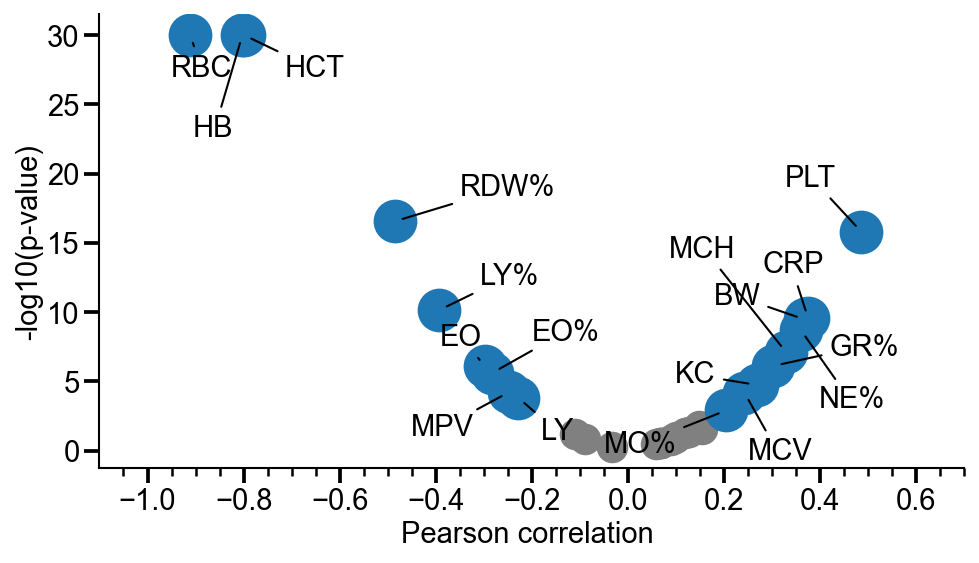

In [5]:
figsize=(fig_size, fig_size * 0.6)
figname = 'fig5b_dfi_volcano'


# Select featurs to include in volcano
features = df_validation_control.columns[4:].tolist()
features.remove('dFI')
features.remove('pfi')

df = df_validation_control.dropna(subset=['dFI'])
df = df.dropna(thresh=int(0.75 * len(df)), axis=1)  # drop columns with NA

df_volcano = pd.DataFrame(columns=['feature', 'cor', 'pval'])
dfi_key = 'dFI'
pval=0.05/len(features)
dfi_mask = plots.medmad(df['dFI'].values, 5)
df = df[~dfi_mask]
print("Animals removed: {:d} (dfi mask)".format(dfi_mask.sum()))
for i, g in enumerate(features):
    if g == dfi_key:
        continue
    elif g not in df.columns:
        continue

    df_ = df[[g, dfi_key]].dropna()
    if len(df_) == 0:
        continue
    mask = plots.medmad(df_[g].values, 5)
    print("Animals removed: {:d} ({:s} mask, {:d} animals included)".format(mask.sum(), g, (~mask).sum()))
    df_volcano.loc[i] = [g, ] + list(scipy.stats.pearsonr(df_[g].values[~mask], df_[dfi_key].values[~mask]))

xl = []
yl = []
ll = []
fig = plt.figure(figsize=figsize, dpi=300)
ax = plt.gca()
cmap = plt.get_cmap('tab10')
for i, row in df_volcano.iterrows():
    x, y = row['cor'], -np.log10(row['pval'])
    y = min(y, 30)
    if y > -np.log10(pval):
        xl.append(x)
        yl.append(y)
        ll.append(row['feature'])
        color_ = cmap.colors[0]
        s_ = 100
    else:
        color_ = 'grey'
        s_ = 50
    scat=ax.scatter(x, y, color=color_, s=s_)
plots.add_text_adjust(xl, yl, plots.rename_features(ll), expand_points=(2.5,2.5), fs=fontsize,
                      force_points=(0.2, 0.3),  force_text=(0.5, 2.), arrowprops=dict(arrowstyle="-", color='k'))

plt.ylabel('-log10(p-value)')
plt.xlabel('Pearson correlation ')
plt.xlim(-1.1, 0.7)

# Save figure and source
fig.tight_layout()
fig.savefig('./figs/{:s}.{:s}'.format(figname, fileformat), bbox_inches=bbox_inches, dpi=300, pad_inches=0)
plt.show()

# Save data source for NC submission
try:
    with pd.ExcelWriter('./source/{:s}.xlsx'.format(figname), engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
        df_volcano.to_excel(writer)
except FileNotFoundError:
    with pd.ExcelWriter('./source/{:s}.xlsx'.format(figname), engine="openpyxl") as writer:
        df_volcano.to_excel(writer)
